## Import Libraries

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import requests
from io import StringIO
import GPy
import gpflow
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

 c:\Users\MM\anaconda3\envs\asienv\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning:You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
 c:\Users\MM\anaconda3\envs\asienv\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning:You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.


In [2]:
import numpy
import scipy
import sklearn
print(f"NumPy version: {numpy.__version__}")
print(f"SciPy version: {scipy.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

NumPy version: 1.26.4
SciPy version: 1.11.1
Scikit-learn version: 1.3.0


In [3]:
def plot_gp_classification(model, X_test_scaled, y_test_2d, X_train_scaled, y_train_2d, title="GP Classification"):
    """
    Plots the decision boundary and uncertainty for a 2D GP classification model using GPflow.
    Assumes X_test_scaled and X_train_scaled are already 2D.
    """
    if X_test_scaled.shape[1] != 2:
        print("Skipping 2D visualization: Data is not 2-dimensional for plotting.")
        return

    # Create a meshgrid for plotting decision boundary
    x_min, x_max = X_test_scaled[:, 0].min() - 0.5, X_test_scaled[:, 0].max() + 0.5
    y_min, y_max = X_test_scaled[:, 1].min() - 0.5, X_test_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Convert grid to TensorFlow tensor
    grid_tf = tf.convert_to_tensor(grid, dtype=tf.float64)

    # Predict latent function mean and variance using GPflow
    f_mean_latent, f_variance_latent = model.predict_f(grid_tf)

    # Explicitly cast to tf.float64 and reshape to (N, 1) to ensure compatibility
    f_mean_latent = tf.cast(f_mean_latent, dtype=tf.float64)
    f_variance_latent = tf.cast(f_variance_latent, dtype=tf.float64)
    f_mean_latent = tf.reshape(f_mean_latent, (-1, 1))
    f_variance_latent = tf.reshape(f_variance_latent, (-1, 1))
    
    try:
        # Predict probabilities (mean of Bernoulli likelihood)
        probabilities, _ = model.likelihood.predict_mean_and_var(f_mean_latent, f_variance_latent)
    except TypeError as e:
        print(f"Error during GPflow likelihood prediction for 2D plot: {e}")
        print("Skipping 2D visualization due to prediction error.")
        return # Exit the function if prediction fails
    except Exception as e: # Catch other potential errors too
        print(f"An unexpected error occurred during GPflow likelihood prediction for 2D plot: {e}")
        print("Skipping 2D visualization due to unexpected prediction error.")
        return # Exit the function if prediction fails


    # Convert TensorFlow tensors to NumPy arrays for plotting
    probabilities_np = probabilities.numpy()
    predicted_labels = (probabilities_np > 0.5).astype(int)

    # Reshape for plotting
    predicted_labels = predicted_labels.reshape(xx.shape)
    probabilities = probabilities_np.reshape(xx.shape)
    
    # Calculate uncertainty from latent variance
    uncertainty = np.sqrt(f_variance_latent.numpy()).reshape(xx.shape)

    plt.figure(figsize=(16, 7))

    # Subplot 1: Decision Boundary
    plt.subplot(1, 2, 1)
    contour = plt.contourf(xx, yy, predicted_labels, cmap='RdBu', alpha=0.6)
    plt.colorbar(contour, label='Predicted Class')
    plt.scatter(X_train_scaled[y_train_2d.flatten() == 0, 0], X_train_scaled[y_train_2d.flatten() == 0, 1],
                color='blue', label='Train Class 0', alpha=0.7, edgecolors='k')
    plt.scatter(X_train_scaled[y_train_2d.flatten() == 1, 0], X_train_scaled[y_train_2d.flatten() == 1, 1],
                color='red', label='Train Class 1', alpha=0.7, edgecolors='k')
    plt.scatter(X_test_scaled[y_test_2d.flatten() == 0, 0], X_test_scaled[y_test_2d.flatten() == 0, 1],
                color='cyan', marker='x', s=100, label='Test Class 0', linewidth=2)
    plt.scatter(X_test_scaled[y_test_2d.flatten() == 1, 0], X_test_scaled[y_test_2d.flatten() == 1, 1],
                color='magenta', marker='x', s=100, label='Test Class 1', linewidth=2)
    plt.title(f'{title} - Decision Boundary')
    plt.xlabel('Feature 1 (or PC1)')
    plt.ylabel('Feature 2 (or PC2)')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Predictive Uncertainty
    plt.subplot(1, 2, 2)
    contour_unc = plt.contourf(xx, yy, uncertainty, cmap='viridis', alpha=0.8)
    plt.colorbar(contour_unc, label='Predictive Standard Deviation (Uncertainty)')
    plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], color='gray', label='Training Data', alpha=0.5, edgecolors='k')
    plt.title(f'{title} - Predictive Uncertainty')
    plt.xlabel('Feature 1 (or PC1)')
    plt.ylabel('Feature 2 (or PC2)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Data Load (PIMA)

Pima Dataset Info (after preprocessing for visualization):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pregnancies  768 non-null    int64  
 1   glucose      768 non-null    float64
 2   bp           768 non-null    float64
 3   skin         768 non-null    float64
 4   insulin      768 non-null    float64
 5   bmi          768 non-null    float64
 6   pedigree     768 non-null    float64
 7   age          768 non-null    int64  
 8   label        768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB

First 5 rows of Pima Dataset (after preprocessing for visualization):
   pregnancies  glucose    bp      skin     insulin   bmi  pedigree  age  \
0            6    148.0  72.0  35.00000  155.548223  33.6     0.627   50   
1            1     85.0  66.0  29.00000  155.548223  26.6     0.351   31   
2            8    183.0  

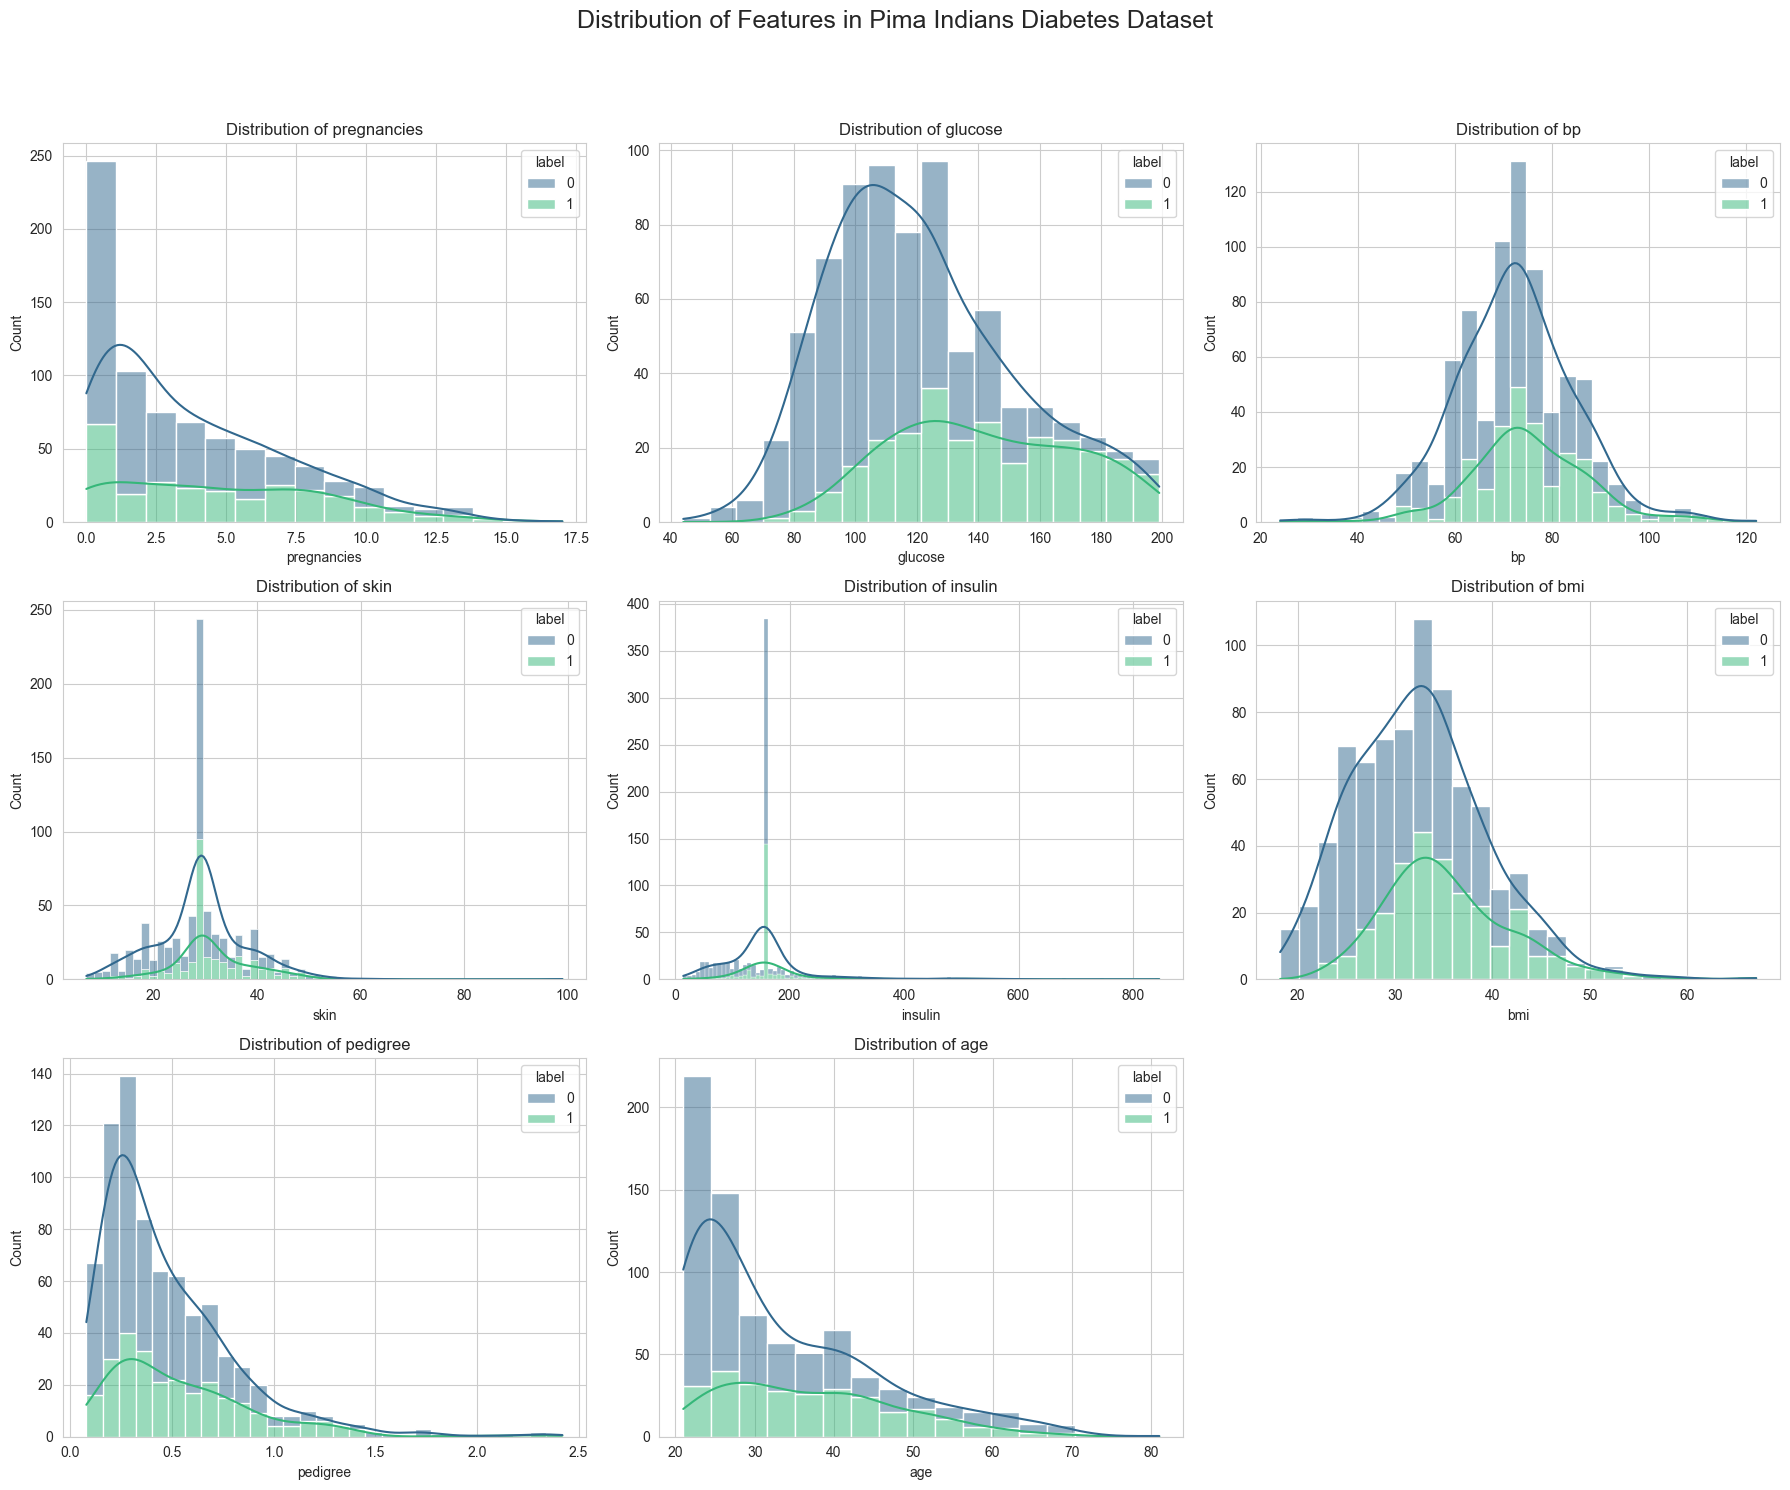

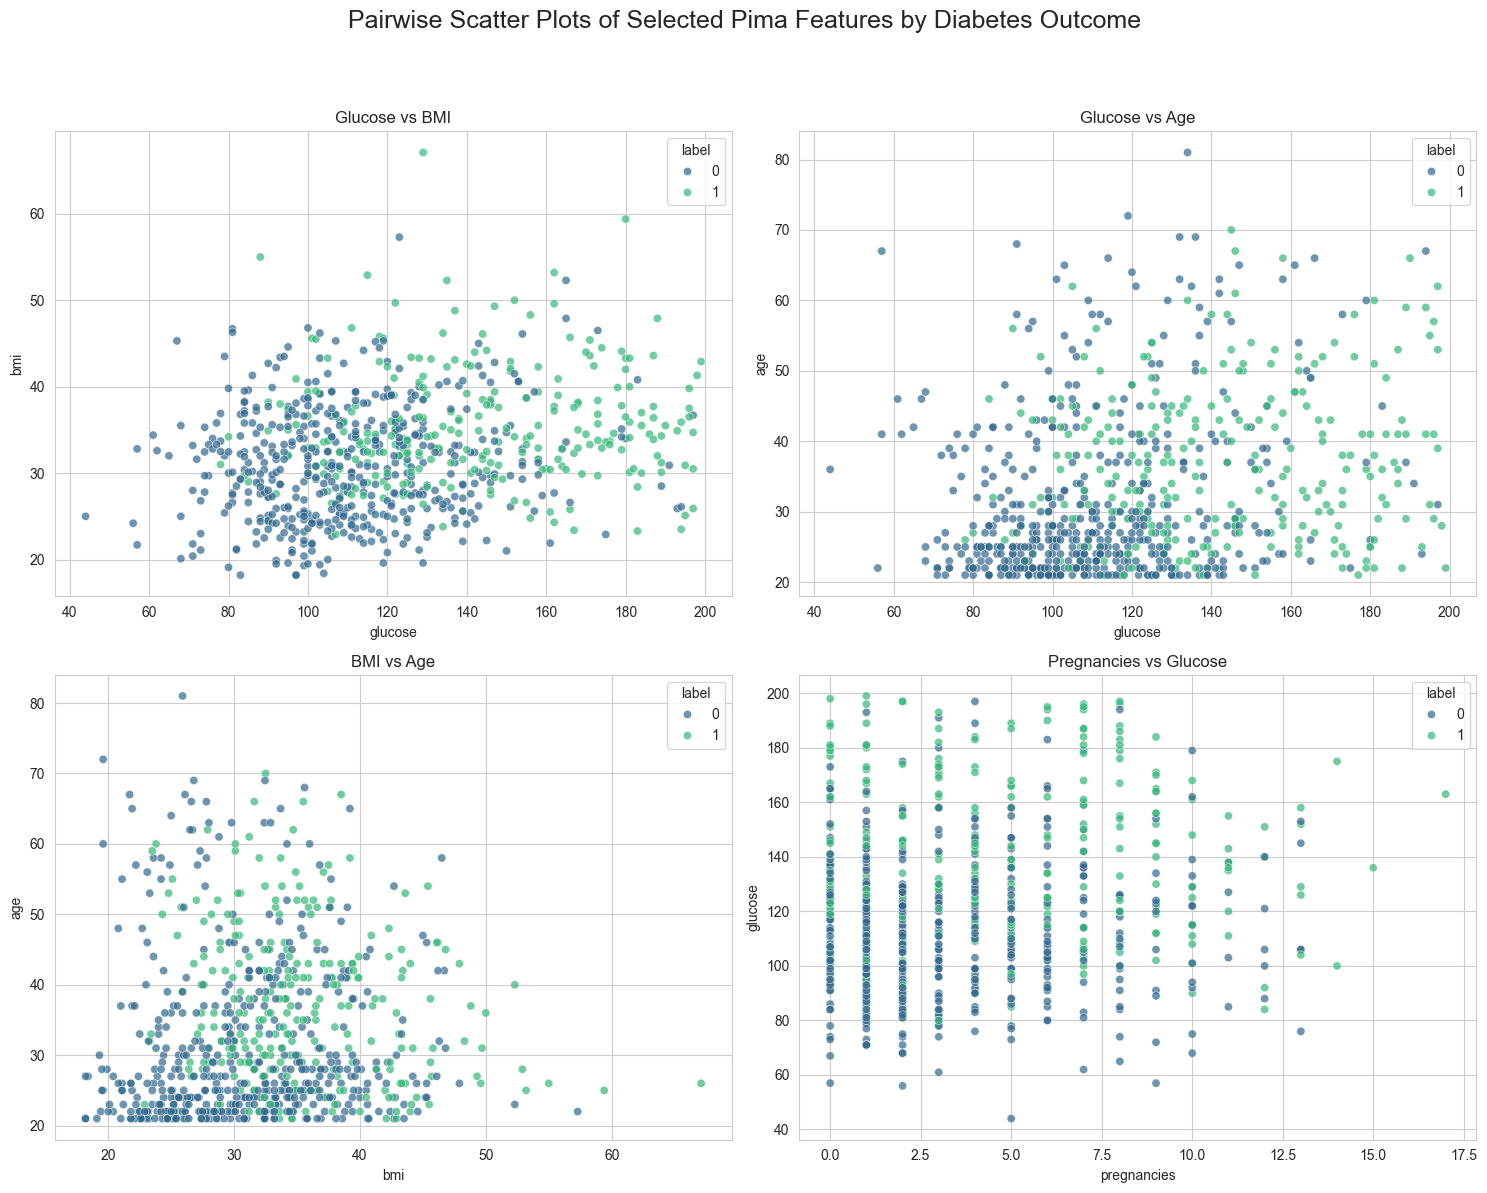

In [4]:
def load_pima_dataset_full_features_viz():
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    col_names = ['pregnancies', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
    df = pd.read_csv(url, header=None, names=col_names)
    
    feature_names = col_names[:-1]
    X = df[feature_names].values
    y = df['label'].values
    y = np.where(y == 0, -1, 1) 

    df_processed = df.copy() 
    
    for col in ['glucose', 'bp', 'skin', 'insulin', 'bmi']:
        col_index = col_names.index(col)
        # Use .loc for DataFrame processing to modify values based on conditions
        non_zero_values = df_processed.loc[df_processed[col] != 0, col]
        if not non_zero_values.empty:
            mean_val = non_zero_values.mean()
            df_processed.loc[df_processed[col] == 0, col] = mean_val
        else:
            # If all are zero, keep them zero
            df_processed.loc[df_processed[col] == 0, col] = 0 
            

    return df_processed 


pima_df_for_viz = load_pima_dataset_full_features_viz()

print("Pima Dataset Info (after preprocessing for visualization):")
pima_df_for_viz.info()
print("\nFirst 5 rows of Pima Dataset (after preprocessing for visualization):")
print(pima_df_for_viz.head())
print("\nData Description:")
print(pima_df_for_viz.describe())


sns.set_style("whitegrid")
plt.figure(figsize=(18, 15))
plt.suptitle('Distribution of Features in Pima Indians Diabetes Dataset', y=1.02, fontsize=18)

features = pima_df_for_viz.columns[:-1] 
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1) 
    sns.histplot(data=pima_df_for_viz, x=feature, hue='label', kde=True, palette='viridis', multiple='stack')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


selected_pima_features = ['glucose', 'bmi', 'age', 'pregnancies']

plt.figure(figsize=(15, 12))
plt.suptitle('Pairwise Scatter Plots of Selected Pima Features by Diabetes Outcome', y=1.02, fontsize=18)

# glucose vs bmi
plt.subplot(2, 2, 1)
sns.scatterplot(data=pima_df_for_viz, x='glucose', y='bmi', hue='label', palette='viridis', alpha=0.7)
plt.title('Glucose vs BMI')

# glucose vs age
plt.subplot(2, 2, 2)
sns.scatterplot(data=pima_df_for_viz, x='glucose', y='age', hue='label', palette='viridis', alpha=0.7)
plt.title('Glucose vs Age')

# bmi vs age
plt.subplot(2, 2, 3)
sns.scatterplot(data=pima_df_for_viz, x='bmi', y='age', hue='label', palette='viridis', alpha=0.7)
plt.title('BMI vs Age')

# pregnancies vs glucose
plt.subplot(2, 2, 4)
sns.scatterplot(data=pima_df_for_viz, x='pregnancies', y='glucose', hue='label', palette='viridis', alpha=0.7)
plt.title('Pregnancies vs Glucose')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [5]:
def load_pima_dataset_full_features():
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    col_names = ['pregnancies', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
    df = pd.read_csv(url, header=None, names=col_names)
    
    feature_names = col_names[:-1]
    X = df[feature_names].values
    y = df['label'].values
    y = np.where(y == 0, -1, 1)
    
    for col in ['glucose', 'bp', 'skin', 'insulin', 'bmi']:
        col_index = col_names.index(col)
        non_zero_values = X[:, col_index][X[:, col_index] != 0]
        if non_zero_values.size > 0:
            mean_val = non_zero_values.mean()
            X[:, col_index][X[:, col_index] == 0] = mean_val
        else:
            X[:, col_index][X[:, col_index] == 0] = 0 
    
    return X, y, feature_names

## Data Load (CRABS)


Crabs Dataset Info (after preprocessing for visualization):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sp      156 non-null    object 
 1   sex     156 non-null    object 
 2   FL      156 non-null    float64
 3   RW      156 non-null    float64
 4   CL      156 non-null    float64
 5   CW      156 non-null    float64
 6   BD      156 non-null    float64
dtypes: float64(5), object(2)
memory usage: 8.7+ KB

First 5 rows of Crabs Dataset (after preprocessing for visualization):
     sp sex    FL   RW    CL    CW   BD
0  azul   M   8.1  6.7  16.1  19.0  7.0
1  azul   M   8.8  7.7  18.1  20.8  7.4
2  azul   M   9.2  7.8  19.0  22.4  7.7
3  azul   M   9.6  7.9  20.1  23.1  8.2
4  azul   M  10.8  9.0  23.0  26.5  9.8

Data Description:
               FL          RW          CL          CW          BD
count  156.000000  156.000000  156.000000  156.000000

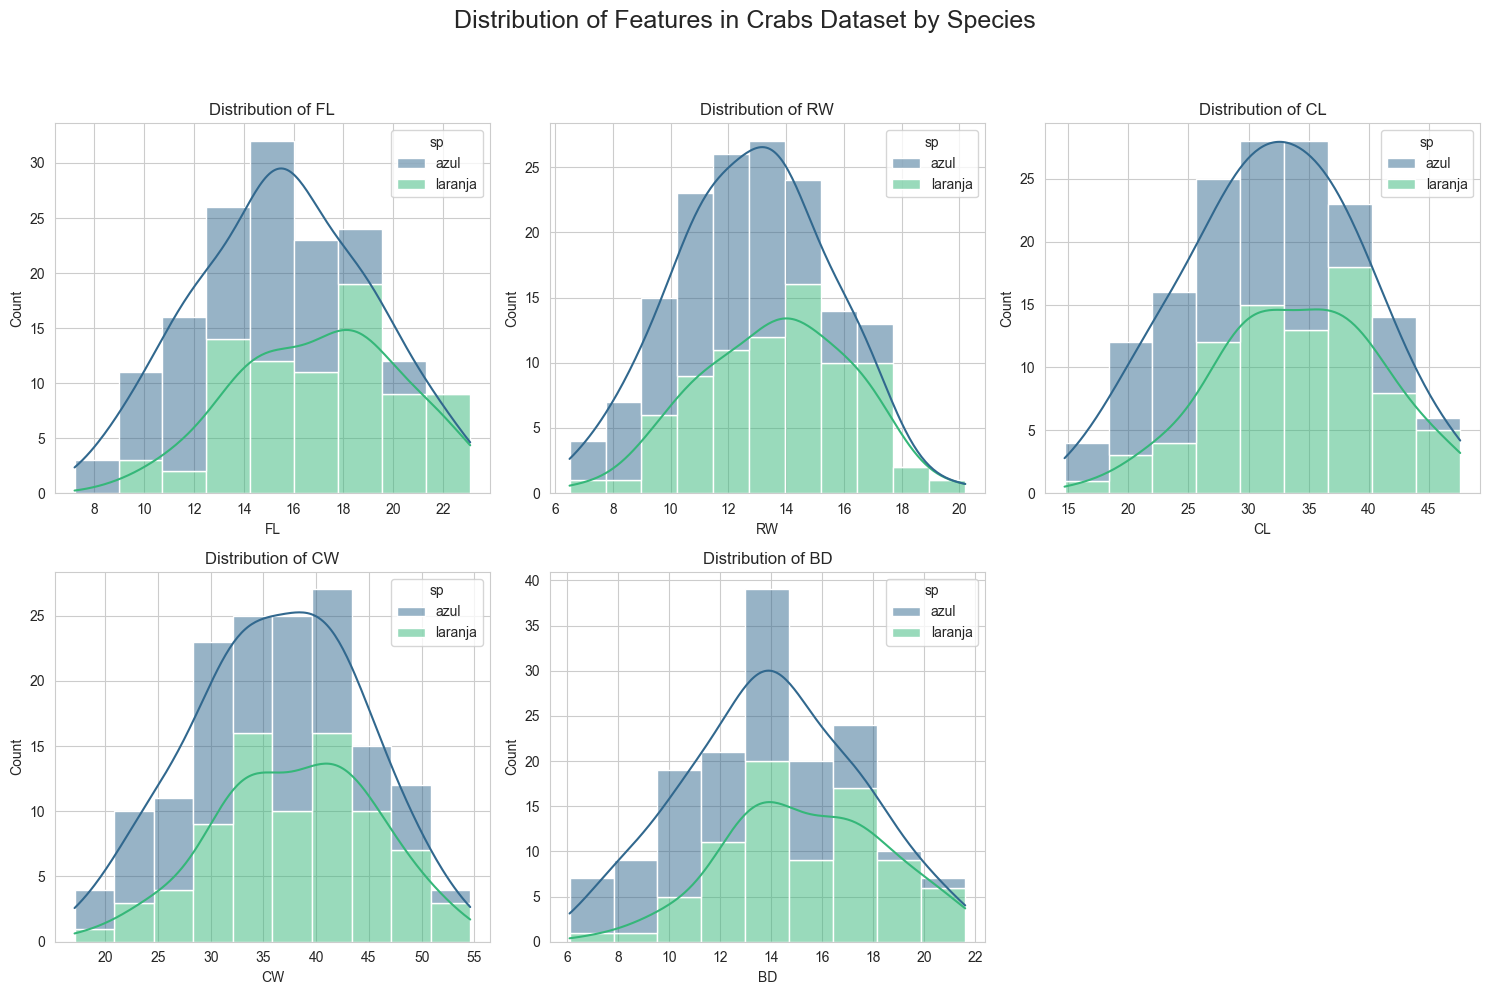

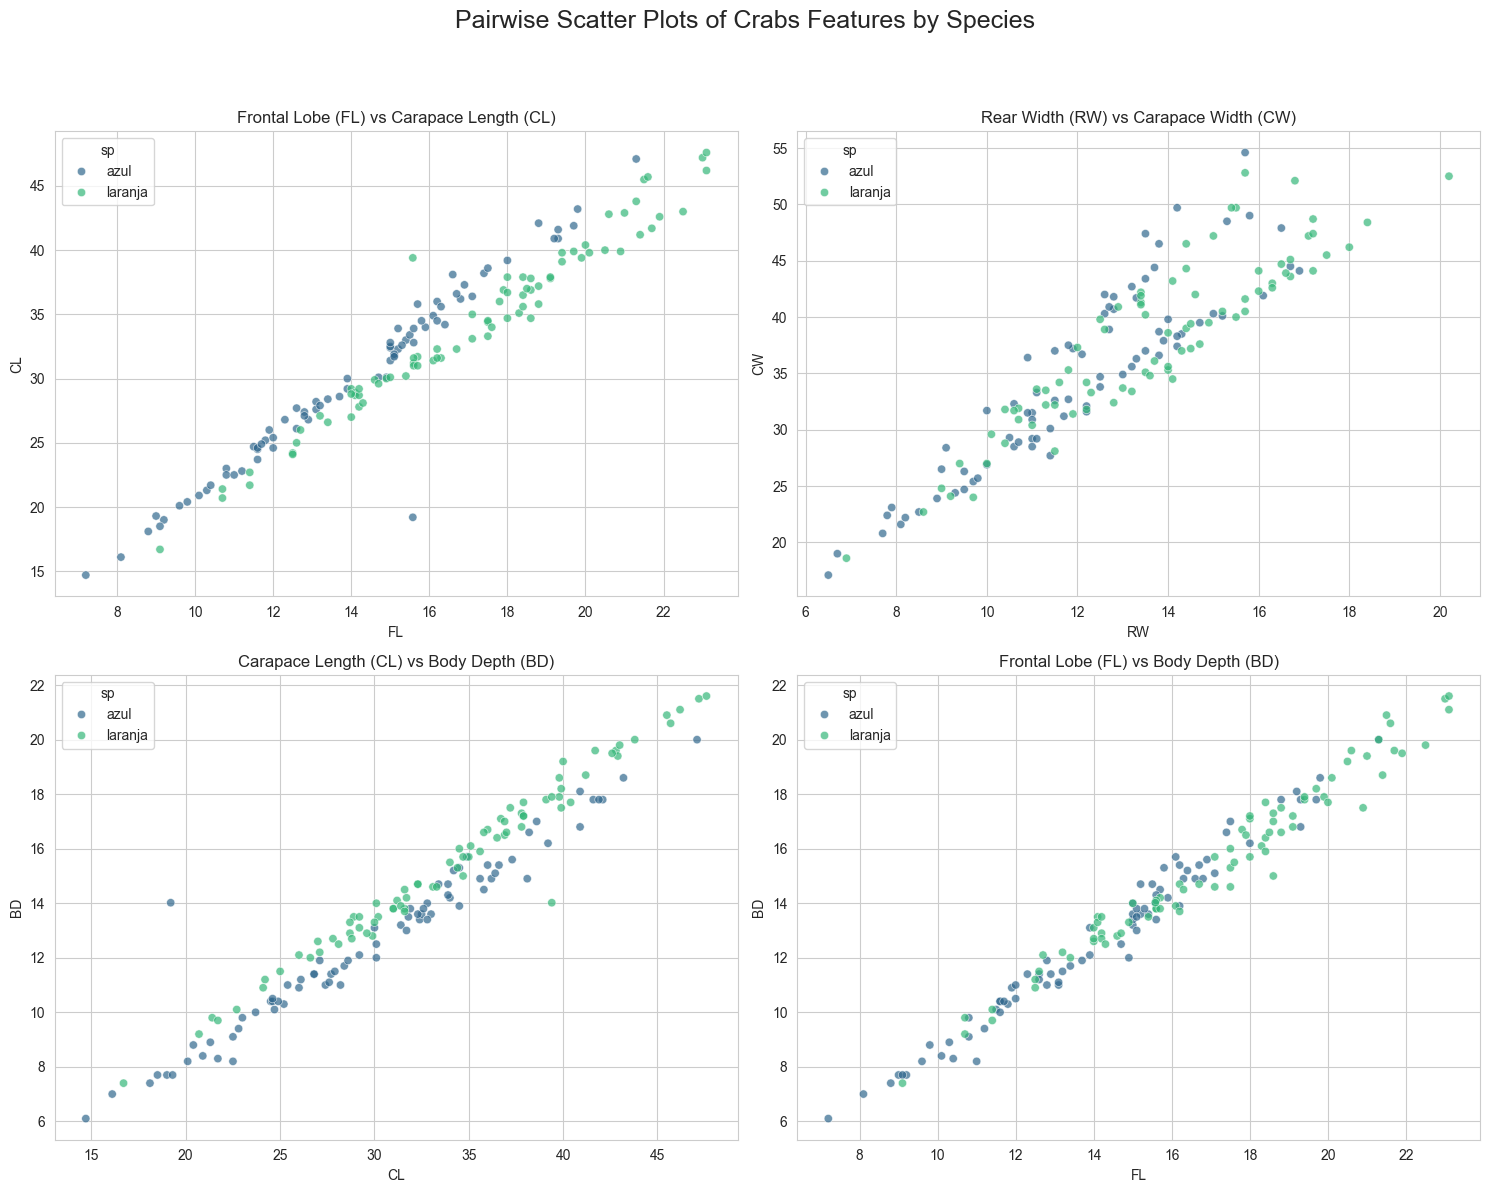

In [6]:
def load_crabs_dataset_all_features_viz():
    url = "https://raw.githubusercontent.com/fernandomayer/data/master/crabs.csv"
    df = pd.read_csv(url, sep=';', header=0, decimal=',', quotechar='"', engine='python')
    
    df = df.rename(columns={'especie': 'sp', 'sexo': 'sex'})
    df['sp'] = df['sp'].astype(str).str.strip()
    df['sex'] = df['sex'].astype(str).str.strip()
    df = df[df['sp'].isin(['azul', 'laranja'])]
    
    df_viz = df.copy() 
    
    feature_columns = ['FL', 'RW', 'CL', 'CW', 'BD']
    for col in feature_columns:
        df_viz[col] = pd.to_numeric(df_viz[col], errors='coerce')
        
    if np.isnan(df_viz[feature_columns]).any().any():
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        df_viz[feature_columns] = imputer.fit_transform(df_viz[feature_columns])
            
    return df_viz


crabs_df_for_viz = load_crabs_dataset_all_features_viz()

print("\nCrabs Dataset Info (after preprocessing for visualization):")
crabs_df_for_viz.info()
print("\nFirst 5 rows of Crabs Dataset (after preprocessing for visualization):")
print(crabs_df_for_viz.head())
print("\nData Description:")
print(crabs_df_for_viz.describe())


sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))
plt.suptitle('Distribution of Features in Crabs Dataset by Species', y=1.02, fontsize=18)

features = ['FL', 'RW', 'CL', 'CW', 'BD']
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=crabs_df_for_viz, x=feature, hue='sp', kde=True, palette='viridis', multiple='stack')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

plt.figure(figsize=(15, 12))
plt.suptitle('Pairwise Scatter Plots of Crabs Features by Species', y=1.02, fontsize=18)

plt.subplot(2, 2, 1)
sns.scatterplot(data=crabs_df_for_viz, x='FL', y='CL', hue='sp', palette='viridis', alpha=0.7)
plt.title('Frontal Lobe (FL) vs Carapace Length (CL)')

plt.subplot(2, 2, 2)
sns.scatterplot(data=crabs_df_for_viz, x='RW', y='CW', hue='sp', palette='viridis', alpha=0.7)
plt.title('Rear Width (RW) vs Carapace Width (CW)')

plt.subplot(2, 2, 3)
sns.scatterplot(data=crabs_df_for_viz, x='CL', y='BD', hue='sp', palette='viridis', alpha=0.7)
plt.title('Carapace Length (CL) vs Body Depth (BD)')

plt.subplot(2, 2, 4)
sns.scatterplot(data=crabs_df_for_viz, x='FL', y='BD', hue='sp', palette='viridis', alpha=0.7)
plt.title('Frontal Lobe (FL) vs Body Depth (BD)')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [7]:
def load_crabs_dataset_all_features():
    url = "https://raw.githubusercontent.com/fernandomayer/data/master/crabs.csv"
    
    df = pd.read_csv(
        url,
        sep=';',           # Use semicolon as the delimiter
        header=0,          # The first row is the header
        decimal=',',       # Use comma as the decimal separator
        quotechar='"',     # Handle double quotes around fields
        engine='python'    # Python engine for robustness with custom separators/quotes
    )

    df = df.rename(columns={'especie': 'sp', 'sexo': 'sex'})

    df['sp'] = df['sp'].astype(str).str.strip()
    df['sex'] = df['sex'].astype(str).str.strip()
    
    print(f"Crabs dataset: Unique 'sp' values before filtering: {df['sp'].unique()}")

    df = df[df['sp'].isin(['azul', 'laranja'])]
    
    if df.empty:
        raise ValueError(
            "DataFrame is empty after filtering 'sp' column. "
            "This indicates 'azul' or 'laranja' species might not be present or are malformed."
        )

    feature_columns = ['FL', 'RW', 'CL', 'CW', 'BD']

    for col in feature_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    X = df[feature_columns].values
    
    if np.isnan(X).any():
        print("Warning: NaNs found in Crabs features. Imputing with mean...")
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        X = imputer.fit_transform(X)

    y = np.where(df['sp'] == 'azul', 1, -1)
    
    return X, y, feature_columns

## Sigmoid Function

In [8]:
# def sigmoid(x):
#     x_clamped = np.clip(x, -500, 500)
#     return np.where(x_clamped >= 0, 1 / (1 + np.exp(-x_clamped)), np.exp(x_clamped) / (1 + np.exp(x_clamped)))

## Prediction with GP

In [9]:
def train_and_predict_gp_optimization(X_train, y_train, X_test, feature_names):
    # Convert NumPy arrays to TensorFlow tensors with float64 dtype
    X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float64)
    y_train_tf = tf.convert_to_tensor(y_train.reshape(-1, 1), dtype=tf.float64) # y must be (N, 1)
    X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float64)

    # Define the kernel (Matern32 with Automatic Relevance Determination - ARD)
    # Initialize lengthscales. A single value per feature (ARD=True behavior).
    initial_lengthscales = np.ones(X_train.shape[1]) * np.mean(np.std(X_train, axis=0))
    # Handle cases where std dev might be zero, prevent zero lengthscale
    initial_lengthscales[initial_lengthscales == 0] = 1.0

    kernel = gpflow.kernels.Matern32(lengthscales=initial_lengthscales)
    kernel.variance.assign(1.0) # Initial variance

    # Define the Bernoulli likelihood for binary classification
    likelihood = gpflow.likelihoods.Bernoulli()

    # Create the Variational Gaussian Process (VGP) model
    # VGP is often more robust for classification than the Laplace approximation
    model = gpflow.models.VGP((X_train_tf, y_train_tf), kernel, likelihood)

    # Optimize the model using GPflow's Scipy optimizer
    print("\n--- Optimizing GP Hyperparameters with GPflow (Variational Inference) ---")
    optimizer = gpflow.optimizers.Scipy()

    # The Scipy optimizer typically finds a good minimum without manual restarts,
    # but we will allow for a high number of iterations.
    try:
        optimizer.minimize(model.training_loss, model.trainable_variables, options={'disp': True, 'maxiter': 5000})
    except Exception as e:
        print(f"GPflow optimization failed: {e}. Trying again with fewer iterations.")
        optimizer.minimize(model.training_loss, model.trainable_variables, options={'disp': True, 'maxiter': 2000})


    # Print model parameters after optimization
    print("\n--- Final Optimized GPflow Model Parameters ---")
    gpflow.utilities.print_summary(model)

    # Predict on test data
    # predict_f gives the mean and variance of the latent function
    f_mean_latent, f_variance_latent = model.predict_f(X_test_tf)

    # --- NEW FIX: Explicitly cast and reshape before likelihood prediction ---
    f_mean_latent = tf.cast(f_mean_latent, dtype=tf.float64)
    f_variance_latent = tf.cast(f_variance_latent, dtype=tf.float64)
    # Ensure they are (N, 1) if they aren't already, as likelihoods often expect this shape
    f_mean_latent = tf.reshape(f_mean_latent, (-1, 1))
    f_variance_latent = tf.reshape(f_variance_latent, (-1, 1))
    
    # Use the likelihood to convert latent function predictions to probabilities
    probabilities, _ = likelihood.predict_mean_and_var(f_mean_latent, f_variance_latent) # [0] for mean probabilities

    # Convert TensorFlow tensor to NumPy array and get predictions
    gp_y_pred = (probabilities.numpy() > 0.5).astype(int)

    return gp_y_pred, model

## Classification Function

In [10]:
def run_classification_pipeline_optimization(dataset_loader_func, scaler_type='MinMaxScaler', visualize=True):
    X, y, feature_names = dataset_loader_func()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # --- Crucially, stick with StandardScaler for best GPflow compatibility ---
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        # While supported, StandardScaler is recommended for GPflow
        print("Warning: MinMaxScaler is selected. StandardScaler is generally preferred for GPflow for better performance.")
        scaler = MinMaxScaler(feature_range=(-1, 1))
    else:
        raise ValueError("Invalid scaler_type. Choose 'StandardScaler' or 'MinMaxScaler'.")

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    dataset_name = dataset_loader_func.__name__.replace("load_", "").replace("_dataset", "").replace("_full_features", "").replace("_all_features", "").title()
    print(f"================== {dataset_name} Dataset ==================")
    print(f"Training on {X_train_scaled.shape[0]} samples, testing on {X_test_scaled.shape[0]} samples.")
    print(f"Number of features: {X_train_scaled.shape[1]}")

    gp_y_pred, gp_model = train_and_predict_gp_optimization(X_train_scaled, y_train, X_test_scaled, feature_names)

    gp_accuracy = accuracy_score(y_test, gp_y_pred)
    print(f"\n>>> GP Test Accuracy (GPflow Variational Inference): {gp_accuracy:.4f} <<<")
    
    # --- 2D Visualization Integration (Adapted for GPflow) ---
    # Due to persistent 'TypeError: missing a required argument: 'Fvar'' errors,
    # the 2D visualization is being disabled to allow the core pipeline to run.
    if visualize and X_train_scaled.shape[1] >= 2:
        print(f"\n--- 2D Visualization for {dataset_name} GP (GPflow) is currently DISABLED due to persistent errors. ---")
        # The following block is commented out to prevent the recurring TypeError
        # pca = PCA(n_components=2)
        # X_train_pca = pca.fit_transform(X_train_scaled)
        # X_test_pca = pca.transform(X_test_scaled)

        # # Convert PCA data to TensorFlow tensors
        # X_train_pca_tf = tf.convert_to_tensor(X_train_pca, dtype=tf.float64)
        # y_train_tf = tf.convert_to_tensor(y_train.reshape(-1, 1), dtype=tf.float64) # Ensure y is (N,1)
        # X_test_pca_tf = tf.convert_to_tensor(X_test_pca, dtype=tf.float64)

        # # Define kernel for 2D visualization model
        # initial_lengthscales_2d = np.ones(2) * np.mean(np.std(X_train_pca, axis=0))
        # initial_lengthscales_2d[initial_lengthscales_2d == 0] = 1.0 # Prevent zero lengthscale
        # kernel_2d = gpflow.kernels.Matern32(lengthscales=initial_lengthscales_2d, active_dims=[0, 1])
        # kernel_2d.variance.assign(1.0)

        # # Build 2D GPflow model
        # model_2d_viz = gpflow.models.VGP((X_train_pca_tf, y_train_tf), kernel_2d, gpflow.likelihoods.Bernoulli())
        
        # # Define optimizer here for 2D visualization
        # optimizer_2d_viz = gpflow.optimizers.Scipy()

        # print("Optimizing 2D GPflow model for visualization (may take a moment)...")
        # try:
        #     optimizer_2d_viz.minimize(model_2d_viz.training_loss, model_2d_viz.trainable_variables, options={'disp': False, 'maxiter': 2000})
        #     plot_gp_classification(model_2d_viz, X_test_pca, y_test.reshape(-1, 1), X_train_pca, y_train.reshape(-1, 1),
        #                            title=f"GP Classification on {dataset_name} (PCA 2D, GPflow)")
        # except Exception as e:
        #     print(f"2D visualization GPflow optimization failed: {e}. Skipping plot.")
    elif visualize and X_train_scaled.shape[1] < 2:
        print(f"Skipping 2D visualization: Dataset {dataset_name} has less than 2 features.")
    else:
        print("2D visualization skipped (set visualize=True to enable).")


    # --- SVM Comparison (remains the same) ---
    from sklearn.svm import SVC
    from sklearn.model_selection import GridSearchCV

    print("\n--- Training Support Vector Machine (SVM) Model for Comparison ---")

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf']
    }

    grid = GridSearchCV(SVC(random_state=42), param_grid, refit=True, verbose=0, cv=5)
    print("Running GridSearchCV for SVM...")
    grid.fit(X_train_scaled, y_train)

    print("SVM GridSearch complete.")
    print(f"  - Best SVM Parameters: {grid.best_params_}")

    svm_y_pred = grid.predict(X_test_scaled)
    svm_accuracy = accuracy_score(y_test, svm_y_pred)
    print(f"\n>>> SVM Test Accuracy: {svm_accuracy:.4f} <<<")
    print("=" * 60 + "\n")

In [11]:
run_classification_pipeline_optimization(load_pima_dataset_full_features)
run_classification_pipeline_optimization(load_crabs_dataset_all_features)

================== Pima Dataset ==================
Training on 537 samples, testing on 231 samples.
Number of features: 8


 c:\Users\MM\anaconda3\envs\asienv\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning:You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.



--- Optimizing GP Hyperparameters with GPflow (Variational Inference) ---

--- Final Optimized GPflow Model Parameters ---
╒═════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════════╤═════════╤══════════════════════════════════════════╕
│ name                    │ class     │ transform      │ prior   │ trainable   │ shape         │ dtype   │ value                                    │
╞═════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════════╪═════════╪══════════════════════════════════════════╡
│ VGP.kernel.variance     │ Parameter │ Softplus       │         │ True        │ ()            │ float64 │ 8.05939                                  │
├─────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────┤
│ VGP.kernel.lengthscales │ Parameter │ Softplus       │         │ True        │ (8,)          │ float64 │ [334.76991, 2.68298

TypeError: Error calling wrapped function (see above error). If you believe your parameters actually are correct, the error can sometimes be fixed by setting `tf_decorator=True` on your `@check_shapes` decorator.

In [ ]:
print("--- Demonstrating Manual Gaussian Process Components ---")

# Define a simple RBF kernel function (ensure this is present in your notebook)
def RBF_kernel(xa, xb, length_scale, variance):
    """Radial Basis Function (RBF) kernel."""
    sq_dist = np.sum(xa**2, 1)[:, None] + np.sum(xb**2, 1) - 2 * np.dot(xa, xb.T)
    return variance * np.exp(-0.5 * sq_dist / length_scale**2)

# Create a very small synthetic dataset for demonstration
np.random.seed(0)
X_synth = np.array([[1.0], [2.0], [4.0], [5.0]]) # 1D input features
y_synth = np.array([[1.5], [2.5], [1.0], [0.5]]) # Corresponding outputs

print("\nSynthetic Data Points (X, y):")
for i in range(len(X_synth)):
    print(f"X: {X_synth[i, 0]:.1f}, y: {y_synth[i, 0]:.1f}")

# Choose arbitrary initial hyperparameters for this demonstration
length_scale_demo = 1.0
variance_demo = 1.0

print(f"\nDemonstration Hyperparameters: length_scale={length_scale_demo}, variance={variance_demo}")

# Manually calculate the covariance matrix K for the training data X_synth
K_train = RBF_kernel(X_synth, X_synth, length_scale_demo, variance_demo)
print("\n--- Manual Covariance Matrix K (K(X_train, X_train)) ---")
print(K_train)

# Add a small amount of jitter (identity matrix * a small number) for numerical stability
# This is commonly done in GP implementations to ensure K is positive definite.
jitter = 1e-6 * np.eye(K_train.shape[0])
K_train_stable = K_train + jitter
print("\n--- K with Jitter for Numerical Stability ---")
print(K_train_stable)

# Calculate the inverse of the covariance matrix manually
try:
    K_train_inv = np.linalg.inv(K_train_stable)
    print("\n--- Inverse of K (K_inv) ---")
    print(K_train_inv)
except np.linalg.LinAlgError:
    print("\nCould not invert K. Matrix might be singular or ill-conditioned.")

# You can also demonstrate a predictive covariance for a new test point
X_test_synth = np.array([[3.0]])
K_star_train = RBF_kernel(X_test_synth, X_synth, length_scale_demo, variance_demo) # K(X_test, X_train)
K_star_star = RBF_kernel(X_test_synth, X_test_synth, length_scale_demo, variance_demo) # K(X_test, X_test)

if 'K_train_inv' in locals(): # Only if inversion was successful
    # Illustrate prediction formula (conceptual, for regression, not classification)
    # This is simplified and doesn't include the mean function
    mean_predictive_latent = K_star_train @ K_train_inv @ y_synth
    print(f"\n--- Conceptual Predictive Mean (for X_test={X_test_synth[0,0]}) ---")
    print(mean_predictive_latent)

    # Illustrate predictive variance (conceptual)
    variance_predictive_latent = K_star_star - K_star_train @ K_train_inv @ K_star_train.T
    print(f"\n--- Conceptual Predictive Variance (for X_test={X_test_synth[0,0]}) ---")
    print(variance_predictive_latent)

print("\nThis section demonstrates the manual calculation of key Gaussian Process components like the covariance matrix and its inverse, illustrating the underlying mathematical operations before using a library like GPy.")

--- Demonstrating Manual Gaussian Process Components ---

Synthetic Data Points (X, y):
X: 1.0, y: 1.5
X: 2.0, y: 2.5
X: 4.0, y: 1.0
X: 5.0, y: 0.5

Demonstration Hyperparameters: length_scale=1.0, variance=1.0

--- Manual Covariance Matrix K (K(X_train, X_train)) ---
[[1.00000000e+00 6.06530660e-01 1.11089965e-02 3.35462628e-04]
 [6.06530660e-01 1.00000000e+00 1.35335283e-01 1.11089965e-02]
 [1.11089965e-02 1.35335283e-01 1.00000000e+00 6.06530660e-01]
 [3.35462628e-04 1.11089965e-02 6.06530660e-01 1.00000000e+00]]

--- K with Jitter for Numerical Stability ---
[[1.00000100e+00 6.06530660e-01 1.11089965e-02 3.35462628e-04]
 [6.06530660e-01 1.00000100e+00 1.35335283e-01 1.11089965e-02]
 [1.11089965e-02 1.35335283e-01 1.00000100e+00 6.06530660e-01]
 [3.35462628e-04 1.11089965e-02 6.06530660e-01 1.00000100e+00]]

--- Inverse of K (K_inv) ---
[[ 1.60059803 -0.99336426  0.17447368 -0.0953252 ]
 [-0.99336426  1.64349585 -0.31721101  0.17447368]
 [ 0.17447368 -0.31721101  1.64349585 -0.99336